In [1]:
from pypal import PALCoregionalized
from pypal.models.gpr import build_coregionalized_model
from pypal.pal.utils import exhaust_loop
import numpy as np
import matplotlib.pyplot as plt 
plt.style.use('ggplot')

We will use the [Binh-Korn test function](https://en.wikipedia.org/wiki/Test_functions_for_optimization), which defines our Pareto front.

In [2]:
def binh_korn(x, y):  # pylint:disable=invalid-name
    """https://en.wikipedia.org/wiki/Test_functions_for_optimization"""
    obj1 = 4 * x ** 2 + 4 * y ** 2
    obj2 = (x - 5) ** 2 + (y - 5) ** 2
    return -obj1, -obj2

In [3]:
def binh_korn_points():
    """Create a dataset based on the Binh-Korn test function"""
    x = np.linspace(0, 5, 100)  # pylint:disable=invalid-name
    y = np.linspace(0, 3, 100)  # pylint:disable=invalid-name
    array = np.array([binh_korn(xi, yi) for xi, yi in zip(x, y)])
    return np.hstack([x.reshape(-1, 1), y.reshape(-1, 1)]), array

In [4]:
x, points = binh_korn_points()

Text(0, 0.5, 'objective 2')

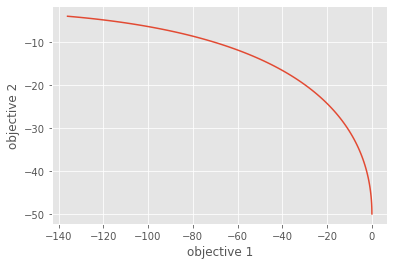

In [5]:
plt.plot(points[:,0], points[:,1])
plt.xlabel('objective 1')
plt.ylabel('objective 2')

We will build a coregionalized Gaussian Process Regression model, using the `build_coregionalized_model` helper function. 
By default, this uses a Matérn-5/2 kernel with automatic relevance determinatation and ICM for the coregionalization.

In [6]:
model = build_coregionalized_model(x, points)

With this model, we can initialize our PAL instance, `PALCoregionalized` will use a logarithmically ($\lg_2$) spaced grid for hyperparameter optimization. Said in other words, the parameters of the GPR model will be optimized on the 0, 2, 4, 16, ... iteration with 20 random initializations.

In [7]:
palinstance = PALCoregionalized(x, [model], 2, beta_scale=1/9, epsilon=[0.05, 0.05])

 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/pypal-0+untagged.131.gb0f431d.dirty-py3.6.egg/pypal/pal/validate_inputs.py:146: UserWarning:No goals provided,                 will assume that every dimension should be maximized


We will need to give it some initial measurements, we pick three points.

In [8]:
indices = np.array([1, 10, 20])

Text(0, 0.5, 'objective 2')

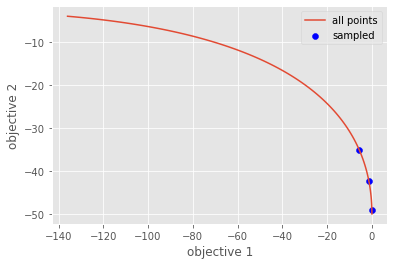

In [9]:
plt.plot(points[:,0], points[:,1], label='all points')
plt.scatter(points[indices,0], points[indices,1], label='sampled', c='b')
plt.legend()
plt.xlabel('objective 1')
plt.ylabel('objective 2')

In [10]:
palinstance.update_train_set(indices, points[indices])

In [13]:
palinstance.run_one_step()

[  0.11209567 -40.08466001] [ -0.11499359 -49.81805998] [-1.44895973e-03 -4.49513600e+01]
[ 3.69315048e-02 -4.00346128e+01] [ -0.13920515 -49.76691843] [ -0.05113682 -44.90076561]
[ 3.56910804e-02 -3.99684036e+01] [ -0.26490702 -49.70386934] [ -0.11460797 -44.83613647]
[-1.84050465e-02 -3.98743890e+01] [ -0.39286395 -49.61250943] [ -0.2056345  -44.74344923]
[ -0.12537402 -39.75182305] [ -0.52559158 -49.49100569] [ -0.3254828  -44.62141437]
[ -0.28431108 -39.59967906] [ -0.6662383  -49.33810019] [ -0.47527469 -44.46888962]
[ -0.49335752 -39.41680365] [ -0.81848904 -49.1530868 ] [ -0.65592328 -44.28494522]
[ -0.74966443 -39.20211075] [ -0.98647019 -48.93575078] [ -0.86806731 -44.06893077]
[ -1.04935002 -38.95479917] [ -1.17465744 -48.6862886 ] [ -1.11200373 -43.82054389]
[ -1.63020422 -38.36184599] [ -1.75842257 -48.09337474] [ -1.69431339 -43.22761037]
[ -1.90679203 -38.01783979] [ -2.15515304 -47.75177841] [ -2.03097254 -42.8848091 ]
[ -2.22059107 -37.64451106] [ -2.57142239 -47.381719

0

In [14]:
palinstance.iteration

2

In [15]:
len(palinstance.uncertainty_wts)

96

In [16]:
palinstance.means

array([[-1.44895973e-03, -4.49513600e+01],
       [-1.38761351e-02, -4.91953882e+01],
       [-5.11368244e-02, -4.49007656e+01],
       [-1.14607972e-01, -4.48361365e+01],
       [-2.05634499e-01, -4.47434492e+01],
       [-3.25482800e-01, -4.46214144e+01],
       [-4.75274694e-01, -4.44688896e+01],
       [-6.55923280e-01, -4.42849452e+01],
       [-8.68067310e-01, -4.40689308e+01],
       [-1.11200373e+00, -4.38205439e+01],
       [-1.38761351e+00, -4.22660953e+01],
       [-1.69431339e+00, -4.32276104e+01],
       [-2.03097254e+00, -4.28848091e+01],
       [-2.39600673e+00, -4.25131151e+01],
       [-2.78743759e+00, -4.21145428e+01],
       [-3.20297782e+00, -4.16914214e+01],
       [-3.64010999e+00, -4.12463140e+01],
       [-4.09616377e+00, -4.07819398e+01],
       [-4.56839211e+00, -4.03010960e+01],
       [-5.05404670e+00, -3.98065809e+01],
       [-5.55045404e+00, -3.52259973e+01],
       [-6.05508585e+00, -3.87872785e+01],
       [-6.56562271e+00, -3.82674272e+01],
       [-7.

Since we already have all the "measurements", we can use the `exhaust_loop` function to loop until there is no unclassified point left.

In [17]:
exhaust_loop(palinstance, points)

[  0.11209567 -40.08466001] [ -0.11499359 -49.81805998] [-1.44895973e-03 -4.49513600e+01]
[ 3.69315048e-02 -4.00346128e+01] [ -0.13920515 -49.76691843] [ -0.05113682 -44.90076561]
[ 3.56910804e-02 -3.99684036e+01] [ -0.26490702 -49.70386934] [ -0.11460797 -44.83613647]
[-1.84050465e-02 -3.98743890e+01] [ -0.39286395 -49.61250943] [ -0.2056345  -44.74344923]
[ -0.12537402 -39.75182305] [ -0.52559158 -49.49100569] [ -0.3254828  -44.62141437]
[ -0.28431108 -39.59967906] [ -0.6662383  -49.33810019] [ -0.47527469 -44.46888962]
[ -0.49335752 -39.41680365] [ -0.81848904 -49.1530868 ] [ -0.65592328 -44.28494522]
[ -0.74966443 -39.20211075] [ -0.98647019 -48.93575078] [ -0.86806731 -44.06893077]
[ -1.04935002 -38.95479917] [ -1.17465744 -48.6862886 ] [ -1.11200373 -43.82054389]
[ -1.63020422 -38.36184599] [ -1.75842257 -48.09337474] [ -1.69431339 -43.22761037]
[ -1.90679203 -38.01783979] [ -2.15515304 -47.75177841] [ -2.03097254 -42.8848091 ]
[ -2.22059107 -37.64451106] [ -2.57142239 -47.381719

[ -9.1722901  -16.58575644] [-26.63703762 -36.85726903] [-18.04155973 -27.95793757]
[ -9.09667339 -15.94866385] [-27.30690909 -36.88926508] [-18.34614839 -27.64779189]
[ -9.0135278  -15.32301766] [-27.96224364 -36.9322831 ] [-18.63977949 -27.34880369]
[ -8.92345046 -14.70939474] [-28.60276703 -36.98541743] [-18.92260507 -27.06081814]
[ -8.82701656 -14.10828977] [-29.22825746 -37.04781359] [-19.19479266 -26.78366467]
[ -8.72477888 -13.52012133] [-29.8385421  -37.11866608] [-19.45652338 -26.51715884]
[ -8.61726766 -12.94523778] [-30.43349377 -37.19721616] [-19.70799017 -26.26110421]
[ -8.50499045 -12.38392284] [-31.01302773 -37.28274956] [-19.94939614 -26.01529395]
[ -8.38843217 -11.83640083] [-31.57709868 -37.37459433] [-20.18095309 -25.77951239]
[ -8.26805522 -11.30284164] [-32.12569781 -37.4721187 ] [-20.40288011 -25.55353646]
[ -8.14429976 -10.78336531] [-32.65885006 -37.57472907] [-20.61540234 -25.3371369 ]
[ -8.01758396 -10.27804636] [-33.17661144 -37.68186807] [-20.81874976 -25.13

[-21.88989488 -27.88559265] [-23.81970845 -36.85951331] [-24.63132556 -39.69146129]
[-23.12943575 -26.70354318] [-24.54380737 -36.83727766] [-25.85003978 -38.45051244]
[-24.42432133 -25.48990596] [-25.25506486 -36.83023338] [-27.11819091 -37.15922472]
[-25.77460749 -24.24109854] [-25.95295952 -36.83725384] [-28.43749797 -35.81584779]
[-27.18020805 -22.9530104 ] [-34.35948338 -36.85726903] [-29.80958277 -34.4187302 ]
[-28.64089996 -21.62102697] [-35.48477502 -36.88926508] [-31.23595128 -32.96633854]
[-30.15632819 -20.24007095] [-36.62499067 -36.9322831 ] [-32.71797371 -31.45727758]
[-31.72601033 -18.80466735] [-37.783161   -36.12141547] [-34.25686351 -29.89031175]
[-33.34934084 -17.30903975] [-38.96249822 -34.39975668] [-35.85365493 -28.26438792]
[-35.02559497 -15.74724573] [-40.166372   -32.63098908] [-37.5091792  -26.57865971]
[-37.04979439 -14.11335862] [-41.39828374 -30.81553169] [-39.22403907 -24.83251335]
[-39.33532429 -12.40169966] [-42.66183913 -28.95396961] [-40.99858171 -23.02

[-53.19470061  -8.84717806] [-53.55164983 -14.71326113] [-53.37621825 -12.83185676]
[-54.95893312  -8.39845753] [-55.25434573 -12.52189825] [-55.10663943 -11.06986519]
[-56.76207128  -7.96371469] [-56.95782255 -10.29626033] [-56.85994691  -9.28456976]
[-58.59373081  -7.54282577] [-58.68242054  -8.03832744] [-58.63807568  -7.47400021]
[-62.26507417   6.25061401] [-62.30281146  -3.43413493] [-62.28394282  -3.76161663]
[-66.0292593  10.1254028] [-66.14902278   1.27227786] [-66.08914104   0.11300493]
[-67.90877756  12.14037446] [-68.22506295   3.65749612] [-68.06692026   2.12686742]
[-69.80757552  14.21420416] [-70.39342766   6.06041626] [-70.10050159   4.19755011]
[-71.73217715  16.35067489] [-72.65241278   8.47813479] [-72.19229497   6.32750688]
[-73.68840631  18.55222817] [-74.99833767  10.90760323] [-74.34337199   8.51782888]
[-75.68133535  20.81988797] [-77.42582309  13.34562193] [-76.55357922  10.76835989]
[-77.71521848  23.15320288] [-79.92807089  15.78883249] [-78.82164468  13.0778

[-128.77353443   70.61004133] [-129.30643315   58.24644723] [-127.70083858   60.6186804 ]
[-130.68063326   72.80843103] [-131.18205616   59.46059547] [-129.90869994   62.86682273]
[-132.52281348   74.92757033] [-132.9259675    60.55036186] [-132.03207679   65.02893919]
[-134.2969084    76.96662001] [-134.53319314   61.9666348 ] [-134.06443344   67.09837485]
Optimization restart 1/20, f = -32.248605664107785
Optimization restart 2/20, f = -92.30003291069384
Optimization restart 3/20, f = -94.5043653710515
Optimization restart 4/20, f = -94.12184300531403
Optimization restart 5/20, f = -93.69330004616155
Optimization restart 6/20, f = -94.40056191355855
Optimization restart 7/20, f = -95.35707300771155
Optimization restart 8/20, f = -93.65917723535019


 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add
 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:565: RuntimeWarning:invalid value encountered in multiply
 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:568: RuntimeWarning:invalid value encountered in subtract


Optimization restart 9/20, f = -93.70523969524677
Optimization restart 10/20, f = -93.1804407510189
Optimization restart 11/20, f = -93.29697499851157
Optimization restart 12/20, f = -92.91581377542086
Optimization restart 13/20, f = -93.8911127936337
Optimization restart 14/20, f = -93.89397169092196
Optimization restart 15/20, f = -93.36514257017294
Optimization restart 16/20, f = -94.35085001622485
Optimization restart 17/20, f = -94.28415812040666
Optimization restart 18/20, f = -93.94491200387526
Optimization restart 19/20, f = -93.90304773083572
Optimization restart 20/20, f = -93.61002416799869
[-23.26351535 -22.68371683] [-23.38830268 -22.71684716] [-23.32590901 -22.700282  ]
[-25.59905207 -21.65139903] [-25.7166557  -21.68274501] [-25.65785388 -21.66707202]
[-26.80640851 -21.14561903] [-26.92252208 -21.17611019] [-26.8644653  -21.16086461]
[-28.04539988 -20.64676097] [-28.15329611 -20.67589628] [-28.09934799 -20.66132863]
[-29.31161724 -20.15554326] [-29.41383067 -20.18280398]

 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/pypal-0+untagged.131.gb0f431d.dirty-py3.6.egg/pypal/models/gpr.py:113: RuntimeWarning:invalid value encountered in sqrt


In [18]:
palinstance.iteration

13

In [19]:
len(palinstance.uncertainty_wts)

31

In [20]:
len(palinstance.rectangle_lows)

100

In [21]:
len(palinstance.rectangle_ups)

100

We should see that there is no unclassified point left

In [19]:
palinstance.number_unclassified_points

0

Since we will get a sparse approximation (ε and β scaling) to the Pareto front, there might be some points missing ...

In [20]:
palinstance.number_pareto_optimal_points

46

Text(0, 0.5, 'objective 2')

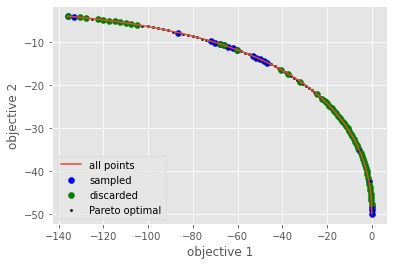

In [21]:
plt.plot(points[:,0], points[:,1], label='all points')
plt.scatter(points[palinstance.sampled_indices,0], 
            points[palinstance.sampled_indices,1], label='sampled', c='b')
plt.scatter(points[palinstance.discarded_indices,0], 
            points[palinstance.discarded_indices,1], label='discarded', c='g')

plt.scatter(points[palinstance.pareto_optimal_indices,0], 
            points[palinstance.pareto_optimal_indices,1], label='Pareto optimal', c='k', s=5)


plt.legend()
plt.xlabel('objective 1')
plt.ylabel('objective 2')

In [22]:
palinstance.number_sampled_points

20

Let's see how it works when we chose other initial points, note that we also choose a smaller epsilon.

In [23]:
model2 = build_coregionalized_model(x, points)
palinstance2 = PALCoregionalized(x, [model2], 2, beta_scale=1/3, epsilon=[0.05, 0.05])

 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/pypal-0+untagged.131.gb0f431d.dirty-py3.6.egg/pypal/pal/validate_inputs.py:146: UserWarning:No goals provided,                 will assume that every dimension should be maximized


In [24]:
indices2 = np.array([5, 20, 30, 50, 60,  70, 80, 95])

Text(0, 0.5, 'objective 2')

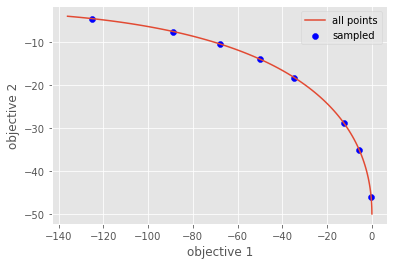

In [25]:
plt.plot(points[:,0], points[:,1], label='all points')
plt.scatter(points[indices2,0], points[indices2,1], label='sampled', c='b')
plt.legend()
plt.xlabel('objective 1')
plt.ylabel('objective 2')

In [26]:
palinstance2.update_train_set(indices2, points[indices2])

In [27]:
exhaust_loop(palinstance2, points)

Optimization restart 1/20, f = -43.765139344550185
Optimization restart 2/20, f = -43.2950561422547
Optimization restart 3/20, f = -44.28622306322037
Optimization restart 4/20, f = 15.698808317570126
Optimization restart 5/20, f = -42.00606705213291
Optimization restart 6/20, f = -43.89415257137575
Optimization restart 7/20, f = -11.76376291158233
Optimization restart 8/20, f = -43.69616102609164
Optimization restart 9/20, f = -11.763762364943151


 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:166: RuntimeWarning:overflow encountered in true_divide
 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:137: RuntimeWarning:overflow encountered in square
 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/GPy/kern/src/stationary.py:138: RuntimeWarning:invalid value encountered in add


Optimization restart 10/20, f = -43.58826474375311
Optimization restart 11/20, f = -44.40242995726039
Optimization restart 12/20, f = -41.67623589609923
Optimization restart 13/20, f = -44.39173893840498
Optimization restart 14/20, f = -44.01954086605736
Optimization restart 15/20, f = -43.228411505850225
Optimization restart 16/20, f = -43.913989419363794
Optimization restart 17/20, f = -44.01639846878522
Optimization restart 18/20, f = -42.94442195339001
Optimization restart 19/20, f = -43.73042341374512
Optimization restart 20/20, f = -43.98106144817783
Done. No unclassified point left


 /Users/brianyoo/anaconda3/lib/python3.6/site-packages/pypal-0+untagged.131.gb0f431d.dirty-py3.6.egg/pypal/models/gpr.py:113: RuntimeWarning:invalid value encountered in sqrt


In [28]:
palinstance2.number_pareto_optimal_points

99

Text(0, 0.5, 'objective 2')

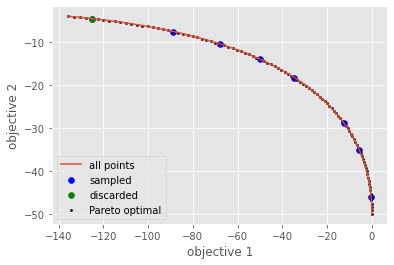

In [29]:
plt.plot(points[:,0], points[:,1], label='all points')
plt.scatter(points[palinstance2.sampled_indices,0], 
            points[palinstance2.sampled_indices,1], label='sampled', c='b')
plt.scatter(points[palinstance2.discarded_indices,0], 
            points[palinstance2.discarded_indices,1], label='discarded', c='g')

plt.scatter(points[palinstance2.pareto_optimal_indices,0], 
            points[palinstance2.pareto_optimal_indices,1], label='Pareto optimal', c='k', s=5)


plt.legend()
plt.xlabel('objective 1')
plt.ylabel('objective 2')